In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from matplotlib import pyplot as plt
import matplotlib

import h5py
from pathlib import Path
textwidth = 6.268
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100

## Todo 

- implement the c electron hamiltonian as a matrix with a static disorder potentional, no disorder and CDW
- diagonalise those and check that they make sense with theory

- Now implement the classical energy routines for the f electrons given a configuration
- implement a metropolis monte-carlo routine, maybe start off without the c-electrons and then add them in.

## Hamiltonian with fixed disorder potential

In the code I'm setting t=1 so I'll write it out like that too.

$$ H = - \sum_{<ij>} c^\dagger_ i c_j + U \sum_i c^\dagger_ i c_i n^f_i - \mu \sum_i (c^\dagger_ i c_i) $$
$$ H = - \sum_{<ij>} c^\dagger_ i c_j + \sum_i c^\dagger_ i c_i (U n^f_i - \mu) $$

In [2]:
%time
def c_electron_hamiltonian(f_electron_occupation, U=0, boundary_condition = 'open'):
    N = len(f_electron_occupation)
    diagonals = [-1, U*f_electron_occupation, -1]
    offsets = [-1, 0, 1]
    
    #make the open hamiltion first because it's tridiagonal
    #can make it closed by adding the extra corner terms later
    H = sparse.diags(diagonals, offsets, shape = (N,N), dtype = np.complex128)
    
    if boundary_condition == 'periodic':
        boundary_terms = sparse.lil_matrix((N,N))
        boundary_terms[0,-1] = -1; boundary_terms[-1,0] = -1;
        
        #do it like this so that python can choose the sparse format to use
        H += boundary_terms
        
    return H

f_electrons = np.ones(200)
H = c_electron_hamiltonian(f_electrons, U=1, boundary_condition='periodic')
print(H.toarray()) 
H

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.7 µs
[[ 1.+0.j -1.+0.j  0.+0.j ...  0.+0.j  0.+0.j -1.+0.j]
 [-1.+0.j  1.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j  1.+0.j -1.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j ...  0.+0.j -1.+0.j  1.+0.j]]


<200x200 sparse matrix of type '<class 'numpy.complex128'>'
	with 600 stored elements in Compressed Sparse Row format>

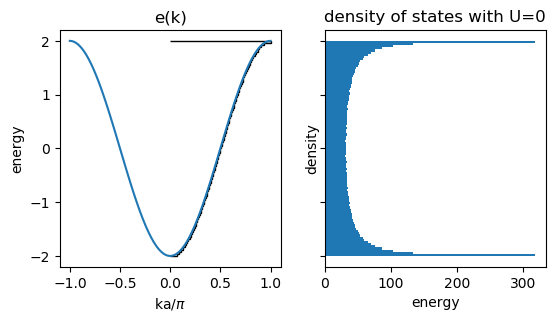

In [3]:
def open_bc_c_electron_solver(f_electron_occupation, U=0):
    diagonal = U*f_electron_occupation
    offdiagonal = -np.ones(len(diagonal)-1) #setting t=1 here
    vals, vecs = sp.linalg.eigh_tridiagonal(d = diagonal, e = offdiagonal)
    vecs = vecs / np.sum(vecs*np.conj(vecs), axis = 0)
    return vals, vecs

N = 5000
f_electrons = np.zeros(N)
vals, vecs = open_bc_c_electron_solver(f_electrons, U=0)
f, (ax, ax2) = plt.subplots(1,2,sharey = 'row', figsize = (1*textwidth,0.5*(textwidth)))
ax2.hist(vals, bins = 100, orientation = 'horizontal');
ax2.set(title = 'density of states with U=0',
       ylabel = 'density',
       xlabel = 'energy'
      )

ax.set(title = 'e(k)',
       ylabel = 'energy',
       xlabel = 'ka/$\pi$'
      );

n, bins, _ = ax.hist(vals, bins = 100, orientation = 'horizontal', cumulative = True, histtype = 'step', density=1, color='black');

ka = np.linspace(-np.pi,np.pi,100)
e = -2*np.cos(ka)
ax.plot(ka/np.pi, e)

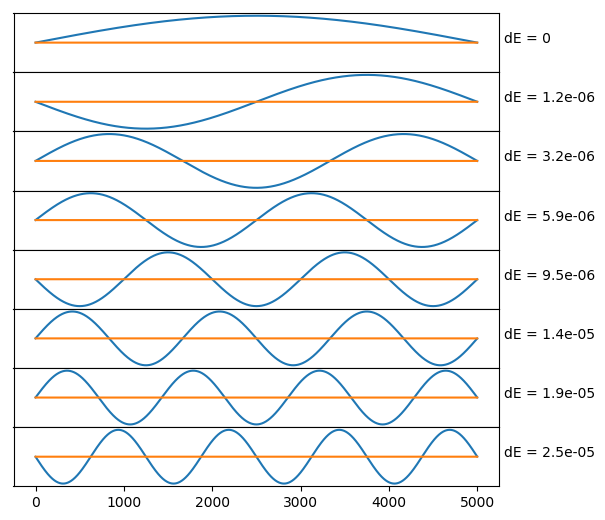

In [4]:
def plot_first_few_eigenvects(vals, vecs, N= 8, order = 1):
    #sort them by energy
    indx = np.argsort(vals)[::order]
    vals = vals[indx]
    vecs = vecs[:, indx]

    f, axes = plt.subplots(N,1, figsize = (textwidth,textwidth),
                           sharex = 'all',
                           sharey = 'all',
                         gridspec_kw = dict(
                         #height_ratios=[2,2,2,2,1,1,1,1],
                         #width_ratios=[2, 2],
                         wspace=0.0,
                         hspace=0.0,
                      )
                          
                          )
    for i,ax in enumerate(axes): 
        ax.plot(np.real(vecs[:, i]))
        ax.plot(np.imag(vecs[:, i]))
        ax.text(1.01,0.5,f'dE = {vals[i] - vals[0]:.2g}',
        transform=ax.transAxes)
        ax.set(yticks = [])


plot_first_few_eigenvects(vals, vecs, N=8, order = 1)

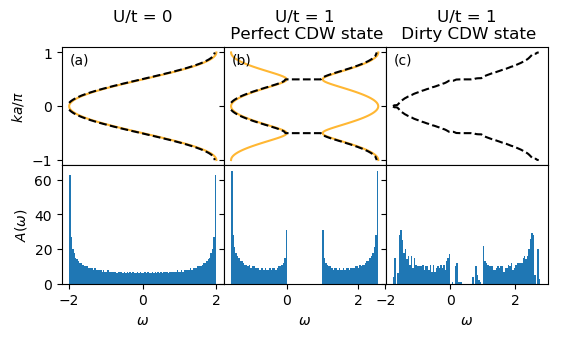

In [5]:
f, axes = plt.subplots(2,3,
                      sharey = 'row',
                      sharex = 'col',
                      figsize = (textwidth,0.5*textwidth), 
                      gridspec_kw = dict(
                         #height_ratios=[2,2,2,2,1,1,1,1],
                         #width_ratios=[2, 2],
                         wspace=0.0,
                         hspace=0.0,
                      )
                     )

axes[0,0].set(
       title = 'U/t = 0\n',
       ylabel = '$ka/\pi$',
      );

axes[0,1].set(
    title  = 'U/t = 1\n Perfect CDW state',
)
axes[0,2].set(
    title  = 'U/t = 1\n Dirty CDW state',
)

axes[1,0].set(
       ylabel = '$A(\omega)$',
      );

#add x axis labels to the bottom row
for a in axes[1]: a.set(xlabel = '$\omega$')
    
#add labels to the top row
for ax, label in zip(axes[0], ('(a)', '(b)', '(c)', '(d)')):
    ax.text(0.05, 0.95, label, transform=ax.transAxes, va='top', ha = 'left')    
    
analytic_kwargs = dict(color = 'orange', alpha = 0.8)
cumulative_hist_kwargs = dict(bins = 100, orientation = 'vertical', cumulative = True, histtype = 'step', density = 1, linewidth = 0)
    
#The U = 0 case
Eax, Aax = axes.T[0]

#plot a A(omega) for U = 0
N = 1000
f_electrons = np.zeros(N)
vals, vecs = open_bc_c_electron_solver(f_electrons, U=0)
normal_hist_kwargs = dict(bins = 100, orientation = 'vertical')
Aax.hist(vals, **normal_hist_kwargs);

#plot the analytic E(k) for U = 0
ka = np.linspace(-np.pi,np.pi,100)
e = -2*np.cos(ka)
Eax.plot(e, ka/np.pi, **analytic_kwargs)

#plot the cumulative histogram into the energy plot for U = 0
n, bins, _ = Eax.hist(vals, **cumulative_hist_kwargs);
Eax.plot(bins[:-1], n, '--k')
Eax.plot(bins[:-1], -n, '--k')

###now the U = 1 perfect CDW order case
Eax, Aax = axes.T[1]
U = 1
f_electrons = np.empty((N,), dtype = np.int)
f_electrons[::2] = 0
f_electrons[1::2] = 1

#plot A(omega) for U = 1 CDW
CDW_vals, CDW_vecs = open_bc_c_electron_solver(f_electrons, U=U)
Aax.hist(CDW_vals, bins = 100, orientation = 'vertical');

#plot the analytic E(k) for U = 1 CDW
ka = np.linspace(-np.pi,np.pi,100)
e = np.sqrt(4*np.cos(ka)**2 + U**2/4)
emin = 1/2 - np.sqrt(4 + 1/4)
Eax.plot(U/2 + e, ka/np.pi, **analytic_kwargs)
Eax.plot(U/2 - e, ka/np.pi, **analytic_kwargs) # need this because in deriving the energy analytically I neglected an additive constant

#plot the cumulative histogram into the energy plot for U = 0 CDW
n, bins, _ = Eax.hist(CDW_vals, **cumulative_hist_kwargs);
Eax.plot(bins[:-1], n, '--k')
Eax.plot(bins[:-1], -n, '--k')

###now the U = 1 perfect CDW order case with 10% of sites flipped uniformly out of order
Eax, Aax = axes.T[2]

perturbation = np.random.choice([1,-1], size=f_electrons.shape[0], p=[0.05,0.95])

perturbed_f_electrons = (f_electrons - 1/2) * perturbation + 1/2
pert_vals, pert_vecs = open_bc_c_electron_solver(perturbed_f_electrons, U=U)
Aax.hist(pert_vals, bins = 100, orientation = 'vertical');

n, bins, _ = Eax.hist(pert_vals, **cumulative_hist_kwargs);
Eax.plot(bins[:-1], n, '--k')
Eax.plot(bins[:-1], -n, '--k')

f.savefig('DoS.pdf')

/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice.
/home/tch14/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


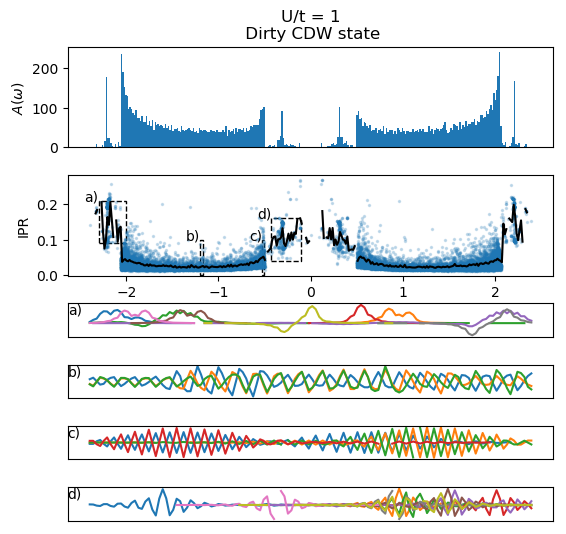

In [6]:
f, axes = plt.subplots(6,1,
                      sharey = 'row',
                      #sharex = 'col',
                      figsize = (textwidth,textwidth), 
                      gridspec_kw = dict(
                         height_ratios=[3,3,1,1,1,1,],
                         #width_ratios=[2, 2],
                         wspace=0.3,
                         hspace=0.5,
                      )
                     )

axes[0].set(
       title  = 'U/t = 1\n Dirty CDW state',
)

axes[0].set(
       ylabel = '$A(\omega)$',
       xticks = [],
      );
axes[1].set(
       ylabel = 'IPR',
      );

#add x axis labels to the bottom row
axes[1].set(xlabel = '$\omega$')

analytic_kwargs = dict(color = 'orange', alpha = 0.8)
    

###now the U = 1 perfect CDW order case with 10% of sites flipped uniformly out of order
Nsystem = 128
Nrepeats = 100
p = 5/100
U = 1

pert_vals = np.zeros(shape = [Nsystem * Nrepeats])
pert_vecs = np.zeros(shape = [Nsystem, Nsystem * Nrepeats])
f_electrons = np.empty((Nsystem,), dtype = np.int)
f_electrons[::2] = 0
f_electrons[1::2] = 1

for i in range(Nrepeats):
    perturbation = np.random.choice([1,-1], size=f_electrons.shape[0], p=[p,1-p])

    perturbed_f_electrons = (f_electrons - 1/2) * perturbation + 1/2
    pert_vals_, pert_vecs_ = open_bc_c_electron_solver(perturbed_f_electrons, U=U)
    pert_vals_ = pert_vals_ - 1/2
    pert_vals[i*Nsystem : (i+1)*Nsystem] = pert_vals_ 
    pert_vecs[:, i*Nsystem : (i+1)*Nsystem] = pert_vecs_

n, bins, _ = axes[0].hist(pert_vals, bins = 300, orientation = 'vertical');

from scipy import fftpack
def smooth(signal, spacing, smoothing_length):
    sig_fft = fftpack.fft(signal)
    sample_freq = fftpack.fftfreq(signal.size, d=spacing)
    smoothed_fft = np.exp(-smoothing_length*np.abs(sample_freq)) * sig_fft
    return fftpack.ifft(smoothed_fft)
    
def IPR(vecs):
    return np.sum((vecs.conj()*vecs)**2, axis = 0) / np.sum((vecs.conj()*vecs), axis = 0)**2
    
smoothed = smooth(n,    
                spacing = bins[1]-bins[0],
                smoothing_length = 0.1,
                 )
    
#Aax.plot(bins[:-1], smoothed)

Aax, Iax, *Phiaxes = axes

#Plot the IPRs against energy
IPRs = IPR(pert_vecs)

#average the IPRs within each energy bin
indx = np.digitize(pert_vals, bins)
bin_averages= np.array([IPRs[indx == i].mean() for i in np.arange(len(bins))])

Iax.plot(pert_vals, IPRs, '.', markersize = 3, alpha = 0.2)
Iax.plot(bins, bin_averages, 'k')

from matplotlib.patches import Rectangle as Rect
boxes = [
    #label (energy range), (IPR range)
    ['a)', [-2.3,-2],[0.09,0.21]],
    ['b)', [-1.2,-1.17],[0,0.1]],
    ['c)', [-0.53,-0.51],[0.0,0.1]],
    ['d)', [-0.43,-0.1],[0.04,0.16]],
    #['d)', [0.1,0.43],[0.04,0.16]],
    #['e)', [1.17,1.2],[0,0.1]],
    #['f)', [2,2.4],[0.09,0.21]],
]
for ax,box in zip(Phiaxes,boxes):
    label, (Emin, Emax), (IPRmin, IPRmax) = box
    Iax.add_patch(Rect((Emin,IPRmin),
                         width = abs(Emax-Emin),
                         height = abs(IPRmax-IPRmin),
                         fill = None,
                         linestyle = '--',
                        ))
    Iax.text(Emin, IPRmax, label, horizontalAlignment = 'right')
    
    ax.set(yticks = [], xticks = [])
    ax.text(0,1,label, transform = ax.transAxes, verticalAlignment = 'top')
    
    indx = (Emin < pert_vals) & (pert_vals < Emax) & (IPRmin < IPRs) & (IPRs < IPRmax)
    assert(len(indx) > 0)
    v = pert_vecs[:, indx][:, ::30]
    if v.size > 0:
        v[abs(v) < 1e-3 * np.max(v)] = np.nan
        assert(np.isnan(v).all() == False)
        ax.plot(np.real(v))
        #ax.plot(np.imag(v))


f.savefig('States.pdf')

In [7]:
%%time
##testing a single quick run
from quantum_montecarlo import quantum_cython_mcmc
config = dict(  N_steps = 10**3,
                N_system = 128,
                mu = 0,
                beta = 0.7,
                V=-1,
                alpha=1.5,
                U = 1,
                output_state = True,
                output_correlator=True,
                output_history=False,
                quantum = True,
                job_id = 1020242,
               )

results = quantum_cython_mcmc(**config)

ModuleNotFoundError: No module named 'stats'

In [8]:
print(results.keys())

print(results['eigenvalue_hist'].shape, results['eigenvector_hist'].shape)

steps, size = results['eigenvalue_hist'][::10, :].shape
pert_vals = np.reshape(results['eigenvalue_hist'][::10, :], [-1])

#swap the axes order so the itertion index and the energy index are next to eachother, reshape and then swap again so that pert_vecs[:, i] is the ith eigenvector
pert_vecs = np.swapaxes(np.reshape(np.swapaxes(results['eigenvector_hist'][::10, :, :], -2, -1), [steps*size, size]), -2, -1)

def IPR(vecs):
    return np.sum((vecs.conj()*vecs)**2, axis = 0) / np.sum((vecs.conj()*vecs), axis = 0)**2
IPRs = IPR(pert_vecs)

print(pert_vals.shape, pert_vecs.shape, IPRs.shape)

NameError: name 'results' is not defined

In [ ]:
f, axes = plt.subplots(6,1,
                      sharey = 'row',
                      #sharex = 'col',
                      figsize = (textwidth,textwidth), 
                      gridspec_kw = dict(
                         height_ratios=[3,3,1,1,1,1,],
                         #width_ratios=[2, 2],
                         wspace=0.3,
                         hspace=0.5,
                      )
                     )

axes[0].set(
       title  = 'U/t = 1\n MCMC states',
)

axes[0].set(
       ylabel = '$A(\omega)$',
       xticks = [],
      );
axes[1].set(
       ylabel = 'IPR',
      );

#add x axis labels to the bottom row
axes[1].set(xlabel = '$\omega$')

analytic_kwargs = dict(color = 'orange', alpha = 0.8)

n, bins, _ = axes[0].hist(pert_vals, bins = 300, orientation = 'vertical');

#average the IPRs within each bin
indx = np.digitize(pert_vals, bins)
bin_averages= np.array([IPRs[indx == i].mean() for i in np.arange(len(bins))])

Aax, Iax, *Phiaxes = axes

Iax.plot(pert_vals, IPRs, '.', markersize = 3, alpha = 0.2)
Iax.plot(bins, bin_averages, 'k')


from matplotlib.patches import Rectangle as Rect
boxes = [
    #label (energy range), (IPR range)
    ['a)', [-2,-1.6],[0.09,0.21]],
    ['b)', [-1.2,-1.17],[0,0.2]],
    ['c)', [-0.53,-0.51],[0.0,0.2]],
    ['d)', [0.3,0.5],[0.2,0.3]],
]
for ax,box in zip(Phiaxes,boxes):
    label, (Emin, Emax), (IPRmin, IPRmax) = box
    Iax.add_patch(Rect((Emin,IPRmin),
                         width = abs(Emax-Emin),
                         height = abs(IPRmax-IPRmin),
                         fill = None,
                         linestyle = '--',
                        ))
    Iax.text(Emin, IPRmax, label, horizontalAlignment = 'right')
    
    ax.set(yticks = [], xticks = [])
    ax.text(0,1,label, transform = ax.transAxes, verticalAlignment = 'top')
    
    indx = (Emin < pert_vals) & (pert_vals < Emax) & (IPRmin < IPRs) & (IPRs < IPRmax)
    assert(len(indx) > 0)
    v = pert_vecs[:, indx][:, ::20]
    if v.size > 0:
        v[abs(v) < 1e-3 * np.max(v)] = np.nan
        assert(np.isnan(v).all() == False)
        ax.plot(np.arange(size), np.real(v))
        #ax.plot(np.imag(v))



f.savefig('mcmc_States.pdf')

# The first few eigenfunctions of the disordered system

In [ ]:
def plot_localised_eigenvects(vals, vecs, N = 8, order = 1):
    #sort them by energy
    indx = np.argsort(vals)[::order]
    vals = vals[indx]
    vecs = vecs[:, indx]

    #normalise the wavefunctions and set the phase such that the first entry is real
    #largest_entries = vecs[np.argmax(vecs*np.conj(vecs), axis = 0), :]
    
    vecs = vecs / np.sum(vecs*np.conj(vecs), axis = 0)

    f, ax = plt.subplots(1,1, figsize = (textwidth,textwidth/3),
                           sharex = 'all',
                           sharey = 'all',
                         gridspec_kw = dict(
                         #height_ratios=[2,2,2,2,1,1,1,1],
                         #width_ratios=[2, 2],
                         wspace=0.0,
                         hspace=0.0,
                      )
                          
                          )
    vecs[abs(vecs) < 1e-5] = np.nan
    O = 500
    ax.plot(np.real(vecs)[:, O:O+N])
    #ax.plot(np.imag(vecs)[:, :N])


plot_localised_eigenvects(pert_vals, pert_vecs, N=10, order = 1)

In [ ]:
plot_localised_eigenvects(pert_vals, pert_vecs, N=6, order = -1)

In [ ]:
def plot_first_few_eigenvects_CDW(vals, vecs, N=8, order = 1):
    #sort them by energy
    indx = np.argsort(vals)[::order]
    vals = vals[indx]
    vecs = vecs[:, indx]

    #normalise the wavefunctions and set the phase such that the first entry is real
    vecs = vecs / np.sum(vecs*np.conj(vecs), axis = 0) / vecs[0, :] * abs(vecs[0, :])

    f, axes = plt.subplots(1,N, figsize = (N*4,4),  sharey = 'all')
    for i,ax in enumerate(axes):
        Ns = np.arange(len(vecs[:, i]))
        ax.plot(Ns[::2], np.real(vecs[::2, i]), label = 'sublattive A')
        ax.plot(Ns[1::2], np.real(vecs[1::2, i]), label = 'sublattive B')
        #ax.set(title = f'e-e_min = {vals[i]-emin:.2g}')


plot_first_few_eigenvects_CDW(CDW_vals, CDW_vecs, N=8)

In these plots of the wavefunctions for the CDW cases, I've plotted the function on each sublattice. The result is just from Bloch's theorem, our effective lattice now have twice the lattive spacing and two sites per unit cell. The two bands correspoond to different wavefunctions within that unit cell. Below are the highest energy wavefunctions:

In [ ]:
plot_first_few_eigenvects_CDW(CDW_vals, CDW_vecs, N=8, order = -1)

In [ ]:
f, ax = plt.subplots(figsize = (0.4*textwidth, 0.4*textwidth))

Ts = np.array([0.1,0.5,1])
U = 4
mu = np.linspace(-6,6,100)
for T in Ts:
    beta = 1/T
    Z =            np.exp(-beta * (U/4 - 0*mu)) +  2*np.exp(-beta * (-U/4 - 1*mu)) +  np.exp(-beta * (U/4 - 2*mu))
    rho = 1/Z * (0*np.exp(-beta * (U/4 - 0*mu)) +1*2*np.exp(-beta * (-U/4 - 1*mu))+ 2*np.exp(-beta * (U/4 - 2*mu)))
    ax.plot(mu, rho, label = f'T = {T:.2f}')
    
ax.set(title = '',
      xlabel = r'$\mu$',
       ylabel = r'$\rho$',
       xticks = [-U/2, 0, U/2],
       xticklabels = ['-U/2', 0, 'U/2'],
       yticks = [0, 1, 2],
      )

ax.legend(loc = 'lower right', fontsize = 8)
f.tight_layout()
f.savefig('single_site_limit.pdf')

In [ ]:
%%time
from math import ceil
f, ax = plt.subplots()
for N in [50,100,200,500,1000]:
    #make a charge density wave
    f_electrons = np.empty((N,), dtype = np.int)
    f_electrons[::2] = 0
    f_electrons[1::2] = 1
    
    p = 5/100
    perturbation = np.random.choice([1,-1], size=f_electrons.shape[0], p=[p,1-p])
    perturbed_f_electrons = (f_electrons - 1/2) * perturbation + 1/2
    vals, vecs = open_bc_c_electron_solver(perturbed_f_electrons, U=1)

    #normalise the wavefunctions
    vecs = vecs / np.sum(vecs*np.conj(vecs), axis = 0)

    IPRs = np.sum(( vecs*np.conj(vecs) )**2, axis = 0)
    ax.scatter(vals[::ceil(N/100)], IPRs[::ceil(N/100)], label = f'N={N}', alpha = 0.8)
ax.legend()

$$ H = - \sum_{<ij>} c^\dagger_ i c_j + U \sum_i c^\dagger_ i c_i n^f_i - \mu \sum_i (c^\dagger_ i c_i) $$
$$ H_c = - \sum_{<ij>} c^\dagger_ i c_j + \sum_i c^\dagger_ i c_i U n^f_i $$

$$ H_f = - \mu \sum_i n^f_i + 4V \sum_{ij} \frac{(-1)^{i-j}}{|i-j|^\alpha} (n^f_i - 1/2) (n^f_j - 1/2)$$

$$ \tau_i = (-1)^i (2n_i^ f - 1) $$
$$ n_i^f = \frac{1}{2}((-1)^i \tau_i + 1) $$

$$ H_f = - \mu \sum_i n^f_i + \sum_{ij} V_{ij} \tau_i \tau_j$$

In [ ]:
from matplotlib import colors

def phase_diagram(working_dir):
    result_filename = working_dir / 'results.hdf5'
    norm = colors.Normalize(vmin=0, vmax=1)

    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])
        Vs = data.attrs['V']
        betas = data.attrs['beta']
        Us = data.attrs['U']

        M = np.array(data['magnetisations_moments'])
        #M[M == 0] = np.nan
        print(M.shape)

        N = len(Vs)
        f, axes = plt.subplots(1,N,
                              figsize = (textwidth, textwidth/(N+1)),
                               sharey = 'all',
                               sharex = 'all',
                              )

        for i,V,ax in zip(range(N),Vs,axes):
            cs = ax.pcolormesh(Us, 1/betas, M[i, :, :, 0], cmap='RdBu_r', norm = norm)
            ax.set(
                title = f'V = {V:.2f}',
                #xlim = [0,5],
                #ylim = [0,1],
                xlabel = 'U'
            )


        f.colorbar(cs, ax=axes, orientation='vertical')
        axes[0].set(ylabel = 'T')
        
phase_diagram(Path('./data/phase_diagram'))

In [ ]:
phase_diagram(Path('./data/phase_diagram_3'))

In [ ]:
phase_diagram(Path('./data/phase_diagram_4'))

In [ ]:
phase_diagram(Path('./data/phase_diagram_5'))

In [ ]:
def phase_diagram_log(working_dir):
    result_filename = working_dir / 'results.hdf5'
    norm = colors.Normalize(vmin=0, vmax=1)

    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])
        Vs = data.attrs['V']
        betas = data.attrs['beta']
        Us = data.attrs['U']

        M = np.array(data['magnetisations_moments'])
        #M[M == 0] = np.nan
        print(M.shape)

        N = len(Vs)
        f, axes = plt.subplots(1,N,
                              figsize = (textwidth*(N+1)/2, textwidth/2),
                               sharey = 'all',
                               sharex = 'all',
                              )

        for i,V,ax in zip(range(N),Vs,axes):
            cs = ax.pcolormesh(Us, 1/betas, M[i, :, :, 0], cmap='RdBu_r', norm = norm)
            ax.set(
                title = f'J* = {V:.2f}',
                #xlim = [0,5],
                #ylim = [0,1],
                xlabel = 'U',
                yscale = 'log',
                xscale = 'log',
            )


        f.colorbar(cs, ax=axes, orientation='vertical')
        axes[0].set(ylabel = 'T')
        f.savefig(f'{working_dir.stem}_log.pdf')

phase_diagram_log(Path('./data/phase_diagram_4'))

In [ ]:
def phase_diagram_log(working_dir):
    result_filename = working_dir / 'results.hdf5'
    norm = colors.Normalize(vmin=0, vmax=1)

    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])
        Vs = data.attrs['V']
        betas = data.attrs['beta']
        Us = data.attrs['U']

        M = np.array(data['magnetisations_moments'])
        #M[M == 0] = np.nan
        print(M.shape)

        N = len(Vs)
        f, axes = plt.subplots(2,N//2,
                              figsize = (textwidth, textwidth/2),
                               sharey = 'all',
                               sharex = 'all',
                               constrained_layout = True,
                              )
        axes = axes.flatten()

        for i,V,ax in zip(range(N),Vs,axes):
            cs = ax.pcolormesh(Us, 1/betas, M[i, :, :, 0], cmap='RdBu_r', norm = norm)
            ax.set(
                title = f'J* = {V:.2f}',
                #xlim = [0,5],
                #ylim = [0,1],
                xlabel = 'U',
                yscale = 'log',
                xscale = 'log',
            )


        f.colorbar(cs, ax=axes, orientation='vertical')
        axes[0].set(ylabel = 'T')
        f.savefig(f'{working_dir.stem}_log.pdf')

phase_diagram_log(Path('./data/phase_diagram_5'))

In [ ]:
phase_diagram_log(Path('./data/phase_diagram_6'))

In [ ]:
def phase_diagram_2(working_dir):
    result_filename = working_dir / 'results.hdf5'
    norm = colors.Normalize(vmin=0, vmax=1)

    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])
        Vs = data.attrs['V']
        betas = data.attrs['beta']
        Us = data.attrs['U']

        M = np.array(data['magnetisations_moments'])
        Merr = np.array(data['magnetisations_moments_err'])
        #M[M == 0] = np.nan
        print(M.shape)

        N = len(Vs)
        f, axes = plt.subplots(2,N,
                              figsize = (textwidth, textwidth*2/3),
                               sharey = 'row',
                               sharex = 'row',
                              )

        for i,V,ax in zip(range(N),Vs,axes[0]):
            cs = ax.pcolormesh(Us, 1/betas, M[i, :, :, 0], cmap='RdBu_r', norm = norm)
            ax.set(
                title = f'V = {V:.2f}',
                #xlim = [0,5],
                #ylim = [0,1],
                xlabel = 'U',
                xscale = 'log',
                yscale = 'log',
            )
            
            U_index = [9, 19, 29, 39, 49]
            #U_index = [10]
            for Ui in U_index:
                #ax.set(title = f'U = {U}')
                line, = ax.plot([Us[Ui], Us[Ui]], [0,5], '--')
                #axes.T[i, 1].plot(1/betas, M[i, :, Ui, 0], color = line.get_color())
                
                axes.T[i, 1].fill_between(1/betas, M[i, :, Ui, 0]+Merr[i, :, Ui, 0],  M[i, :, Ui, 0]-Merr[i, :, Ui, 0], color = line.get_color(), alpha = 0.5)
                axes.T[i, 1].set(
                    xscale = 'log',
                )


        f.colorbar(cs, ax=axes, orientation='vertical')
        axes[0,0].set(ylabel = 'T')
        
working_dir = Path('./data/phase_diagram_4')
phase_diagram_2(working_dir)

In [ ]:
def phase_diagram_correlations(working_dir):
    result_filename = working_dir / 'results.hdf5'
    norm = colors.Normalize(vmin=0, vmax=1)

    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])
        Vs = data.attrs['V']
        betas = data.attrs['beta']
        Ts = 1/betas
        Us = data.attrs['U']

        M = np.array(data['magnetisations_moments'])
        C = np.array(data['correlator'])
        E = np.array(data['q_energy_histogram'])
        
        #M[M == 0] = np.nan
        print(M.shape)

        N = len(Vs)
        f, axes = plt.subplots(1,2,
                    figsize = (textwidth, textwidth/3),
                    gridspec_kw = dict(
                         #height_ratios=[3,3,1,1,1,1,],
                         width_ratios=[2, 5],
                         wspace=0.5,
                         #hspace=0.2,
                      )
                    )

        cs = axes[0].pcolormesh(Us, Ts, M[1, :, :, 0], cmap='RdBu_r', norm = norm)
        axes[0].set(
            title = f'V = -1',
            #xlim = [0,5],
            #ylim = [0,1],
            xlabel = 'U'
        )
        
        Tpoints = [10, 35, 45]
        Upoints = [25,25,25]
        for Ti, Ui in zip(Tpoints, Upoints):
            point, = axes[0].plot(Us[Ui], Ts[Ti], 'o', markersize = 5)
            axes[1].plot(C[1, Ti, Ui], color = point.get_color())
            #axes[2].plot(E[1, Ti, Ui], color = point.get_color())



        #f.colorbar(cs, ax=axes, orientation='vertical')
        axes[0].set(ylabel = 'T')
        
working_dir = Path('./data/phase_diagram_3')
phase_diagram_correlations(working_dir)

In [ ]:
def phase_diagram_correlations_log(working_dir):
    result_filename = working_dir / 'results.hdf5'
    norm = colors.Normalize(vmin=0, vmax=1)

    with h5py.File(result_filename, 'r') as data:
        print(list(data.keys()))
        print(data.attrs['loop_over'])
        Vs = data.attrs['V']
        betas = data.attrs['beta']
        Ts = 1/betas
        Us = data.attrs['U']

        M = np.array(data['magnetisations_moments'])
        C = np.array(data['correlator'])
        E = np.array(data['q_energy_histogram'])
        
        #M[M == 0] = np.nan
        print(M.shape)

        N = len(Vs)
        f, axes = plt.subplots(1,2,
                    figsize = (textwidth, textwidth/3),
                    gridspec_kw = dict(
                         #height_ratios=[3,3,1,1,1,1,],
                         width_ratios=[2, 5],
                         wspace=0.5,
                         #hspace=0.2,
                      )
                    )

        cs = axes[0].pcolormesh(Us, Ts, M[0, :, :, 0], cmap='RdBu_r', norm = norm)
        axes[0].set(
            title = f'V = -1',
            #xlim = [0,5],
            #ylim = [0,1],
            xlabel = 'U',
            xscale = 'log',
            yscale = 'log'
        )
        
        Tpoints = [10, 35, 45]
        Upoints = [25,25,25]
        for Ti, Ui in zip(Tpoints, Upoints):
            point, = axes[0].plot(Us[Ui], Ts[Ti], 'o', markersize = 5)
            axes[1].plot(C[1, Ti, Ui], color = point.get_color())
            #axes[2].plot(E[1, Ti, Ui], color = point.get_color())



        #f.colorbar(cs, ax=axes, orientation='vertical')
        axes[0].set(ylabel = 'T')
        
working_dir = Path('./data/phase_diagram_4')
phase_diagram_correlations_log(working_dir)

## Classical f electrons only

defining the tau representation as
$$ \tau_i = (-1)^i (2n_i^ f - 1) $$
$$ n_i^f = \frac{1}{2}((-1)^i \tau_i + 1) $$

In [ ]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

f, ax = plt.subplots(figsize = (textwidth, textwidth/10),
                     constrained_layout=True,
                    )

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot([1,1], [0,0.3], 'k--', linewidth = 0.5)
ax.plot([2,2], [0,0.3], 'k--', linewidth = 0.5)

# Only show ticks on the left and bottom spines
ax.set(yticks = [], 
       xticks = [1, 1.5, 2, 3],
       xticklabels = [1, r'3/2', 2, ''],
       xlim = [0.7,2.3])

ax.text(0.95,0.1, 'Non-Extensive', horizontalalignment='right')
ax.text(2.05,0.1, 'Short-Ranged')
#ax.text(1.5,0.4, r'$\alpha$', fontsize = 14, horizontalalignment='center')
ax.text(1.5,0.1, r'FTPT', horizontalalignment='center')
f.savefig('alpha_diagram.pdf')
